# Exploring precision and recall

The goal of this notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.

In [1]:
import pandas as pd
import numpy as np

In [2]:
B = np.array([[42,56,89,65],
              [99,88,42,12],
              [55,42,17,18]])
print(B.shape)
print(B[B >= 42])

(3, 4)
[42 56 89 65 99 88 42 55 42]


In [3]:
dtype_dict = {'name':str,
              'review':str, 
              'rating':int}

In [4]:
products = pd.read_csv('amazon_baby.csv', dtype = dtype_dict)

In [5]:
products.head(2)

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5


In [6]:
products.shape

(183531, 3)

# Extract word counts and sentiments

As in the first assignment of this course, we compute the word counts for individual words and extract positive and negative sentiments from ratings. To summarize, we perform the following:

1. Remove punctuation.
2. Remove reviews with "neutral" sentiment (rating 3).
3. Set reviews with rating 4 or more to be positive and those with 2 or less to be negative.

In [7]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [8]:
import string

In [9]:
products['review_without_punctuation']=products['review'].str.replace('[{}]'.format(string.punctuation), '')

In [10]:
# Drop neutral sentiment reviews.
products = products[products['rating'] != 3]
# Positive sentiment to +1 and negative sentiment to -1
products['sentiments'] = products['rating'].apply(lambda rating: 1 if rating > 3 
                                                 else -1)

## Split data into training and test sets

We split the data into a 80-20 split where 80% is in the training set and 20% is in the test set.

In [11]:
import json

with open('train-idx.json', 'r') as f:
    train_index= json.load(f)
    
    
with open('test-idx.json', 'r') as f:
    test_index = json.load(f)

In [12]:
products.head(1)

,name,review,rating,review_without_punctuation,sentiments
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1


In [104]:
train_data = products.iloc[train_index]
test_data = products.iloc[test_index]

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_without_punctuation'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_without_punctuation'])

In [15]:
train_Y = train_data['sentiments']
#train_data = train_data.drop(['rating'], axis = 1)
test_Y = test_data['sentiments']
#test_data = test_data.drop(['rating'], axis = 1)

In [16]:
from sklearn import linear_model

In [17]:
model = linear_model.LogisticRegression()
model.fit(train_matrix, train_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Model Evaluation

## Accuracy


In [18]:
print((model.coef_>0).sum())
print((model.coef_<0).sum())
print((model.coef_==0).sum())

85837
35869
0


In [19]:
def get_classification_accuracy(model, data, true_labels):
    # First get the predictions
    
    predictions = model.predict(data)
    
    # Compute the number of correctly classified examples
    accuracy = (predictions == true_labels).sum()/(len(true_labels))

    # Then compute accuracy by dividing num_correct by total number of examples
    
    return accuracy

In [20]:
get_classification_accuracy(model, test_matrix, test_Y)

0.93238540916726664

## Baseline: Majority class prediction

In [21]:
baseline = sum(train_Y == 1)/len(train_Y)
print ("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.840708760568


In [22]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_Y, y_pred=model.predict(test_matrix))
print ("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.932385409167


In [23]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_Y,
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   801
      1       |        1        | 27294


In [24]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_Y, 
                            y_pred=model.predict(test_matrix))
print ("Precision on test data: %s" % precision)

Precision on test data: 0.949455595366


In [25]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_Y,
                      y_pred=model.predict(test_matrix))
print ("Recall on test data: %s" % recall)

Recall on test data: 0.971489588895


In [26]:
def apply_threshold(probabilities, threshold):
    ### YOUR CODE GOES HERE
    array =  [ 1 if x>=threshold else -1 for x in probabilities ]
    return array

In [121]:
probabilities = model.predict_proba(test_matrix)[:,1]


predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

In [28]:
len(predictions_with_default_threshold)

33336

In [29]:
ones_ = np.ones(len(predictions_with_default_threshold))
print("Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == ones_).sum())

Number of positive predicted reviews (threshold = 0.5): 28747


In [30]:
print ("Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == ones_).sum())

Number of positive predicted reviews (threshold = 0.9): 25074


## Exploring the associated precision and recall as the threshold varies

In [31]:
precision_with_default_threshold = precision_score(y_true=test_Y, 
                            y_pred=predictions_with_default_threshold)

recall_with_default_threshold = recall_score(y_true=test_Y, 
                            y_pred=predictions_with_default_threshold)

precision_with_high_threshold = precision_score(y_true=test_Y, 
                            y_pred=predictions_with_high_threshold)

recall_with_high_threshold = recall_score(y_true=test_Y, 
                            y_pred=predictions_with_high_threshold)


In [32]:
print ("Precision (threshold = 0.5): %s" % precision_with_default_threshold)
print ("Recall (threshold = 0.5)   : %s" % recall_with_default_threshold)

Precision (threshold = 0.5): 0.949455595366
Recall (threshold = 0.5)   : 0.971489588895


In [33]:
print("Precision (threshold = 0.9): %s" % precision_with_high_threshold)
print ("Recall (threshold = 0.9)   : %s" % recall_with_high_threshold)

Precision (threshold = 0.9): 0.981534657414
Recall (threshold = 0.9)   : 0.875992169425


## Precision-recall curve


In [34]:
threshold_values = np.linspace(0.5, 1, num=100)

In [122]:
precision_all = []
recall_all = []

#probabilities = model.predict(test_data, output_type='probability')
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(y_true=test_Y, 
                            y_pred=predictions)
    recall = recall_score(y_true=test_Y, 
                            y_pred=predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

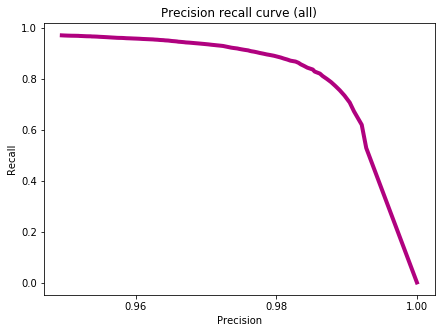

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

In [36]:
precision_all[0:5]

[0.94945559536647306,
 0.94979458254996174,
 0.95036079060201484,
 0.95077620791906503,
 0.95129700101246373]

In [37]:
for i in range(len(precision_all)):
    if(precision_all[i]>=0.965):
        print('threshold: ', threshold_values[i])
        break

threshold:  0.707070707071


Quiz Question: Using threshold = 0.98, how many false negatives do we get on the test_data?

In [38]:
predictions = apply_threshold(probabilities, 0.98)
cmat = confusion_matrix(y_true=test_Y,
                        y_pred=predictions,
                        labels=model.classes_)

In [39]:
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5049
     -1       |        1        |   192
      1       |       -1        |  8239
      1       |        1        | 19856


In [144]:
predictions = apply_threshold(probabilities, 0)
cmat = confusion_matrix(y_true=test_Y,
                        y_pred=predictions,
                        labels=model.classes_)
recall = recall_score(y_true=test_Y, 
                            y_pred=predictions)
print(recall)

1.0


# Evaluating specific search terms

So far, we looked at the number of false positives for the **entire test set**. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

## Precision-Recall on all baby related items

From the **test set**, select all the reviews for all products with the word 'baby' in them.

In [40]:
test_data.dtypes

name                          object
review                        object
rating                         int32
review_without_punctuation    object
sentiments                     int64
dtype: object

In [41]:
test_data.head(2)

,name,review,rating,review_without_punctuation,sentiments
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
10,"Baby Tracker&reg; - Daily Childcare Journal, S...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1


In [77]:
test_matrix.shape
a = np.array([1, 2, 3])>2
print(test_matrix.shape)

(33336, 121706)


In [105]:
test_data['name'] = test_data['name'].apply(lambda x: str(x).lower())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [106]:
baby_reviews_indi = (test_data['name'].apply(lambda x: 'baby' in str(x))).values

In [107]:
test_data.head(2)

,name,review,rating,review_without_punctuation,sentiments
9,"baby tracker&reg; - daily childcare journal, s...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
10,"baby tracker&reg; - daily childcare journal, s...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1


In [108]:
np.transpose(baby_reviews_indi)[0:5]

array([ True,  True, False, False, False], dtype=bool)

In [89]:
baby_reviews=[]

In [124]:
baby_reviews = test_matrix[baby_reviews_indi]

In [112]:
baby_reviews.shape

(6611, 121706)

In [128]:
probabilities2 = model.predict_proba(baby_reviews)[:,1]

In [132]:
threshold_values = np.linspace(0.5, 1, num=100)

In [129]:
baby_Y = test_Y[baby_reviews_indi]

In [130]:
print(len(baby_Y))

6611


In [138]:
print(probabilities2.shape)
print(baby_Y.shape)

(6611,)
(6611,)


In [141]:
precision2_all = []
recall2_all = []

for threshold in threshold_values:
    
    # Make predictions. Use the `apply_threshold` function 
    predictions = apply_threshold(probabilities2, threshold)
    
    precision = precision_score(y_true=baby_Y.values, y_pred=predictions)
    
    recall = recall_score(y_true=baby_Y.values, 
                            y_pred=predictions)
    
    precision2_all.append(precision)
    recall2_all.append(recall)

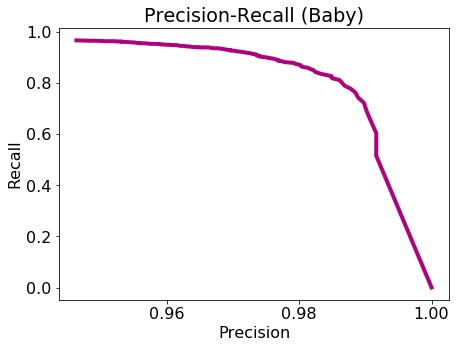

In [142]:
   
plot_pr_curve(precision2_all, recall2_all, "Precision-Recall (Baby)")

In [143]:
for i in range(len(precision2_all)):
    if(precision2_all[i]>=0.965):
        print('threshold: ', threshold_values[i])
        break

threshold:  0.727272727273
